In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pandas import DataFrame
from sklearn import datasets
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RepeatedKFold

In [3]:
from scipy.stats import pearsonr
from numpy import Inf


def loadings_similarity_simple(pipeline, data, limit_to_n_components=Inf, cv=KFold(), method=pearsonr, threshold=0.5):
    """The simplified version of the algorithm"""
    result = []
    keeps = []
    train_pipeline = clone(pipeline)
    test_pipeline = clone(pipeline)

    for train, test in cv.split(data):

        train = data[train]
        test = data[test]

        train_pipeline.fit(train)
        train_pca = train_pipeline.steps[-1][1]
        train_loadings = train_pca.components_

        test_pipeline.fit(test)
        test_pca = test_pipeline.steps[-1][1]
        test_loadings = test_pca.components_

        components_n = min(limit_to_n_components, len(train_loadings))

        cv_keeps = []

        for n in range(1, components_n + 1):

            abs_correlations = []

            trained_loading = train_loadings[n - 1]

            components_m = min(components_n, len(test_loadings))

            corresponding_pc_in_test = None
            keep = False

            for m in range(1, components_m + 1):
                test_loading = test_loadings[m - 1]
                correlation, pvalue = method(test_loading, trained_loading)
                abs_correlation = abs(correlation)

                abs_correlations.append(abs_correlation)

                if abs_correlation >= threshold:
                    keep = True
                    corresponding_pc_in_test = m
                    break

            cv_keeps.append(keep)

            result.append({
                'n': n,
                'best_abs_corr': max(abs_correlations),
                'threshold': threshold,
                'corresponding_pc_in_test': corresponding_pc_in_test,
                'keep': keep,
            })

        keeps.extend([sum(cv_keeps)] * components_n)

    df = DataFrame(result)
    df['keep_n'] = keeps
    return df

## Example: Iris dataset

In [4]:
iris = datasets.load_iris()

In [5]:
pipeline = make_pipeline(StandardScaler(), PCA())
pca_cv = loadings_similarity_simple(pipeline, iris.data, cv=KFold(), threshold=0.5)
pca_cv.head()

,n,best_abs_corr,threshold,corresponding_pc_in_test,keep,keep_n
0,1,0.666479,0.5,2,True,4
1,2,0.616673,0.5,1,True,4
2,3,0.866582,0.5,3,True,4
3,4,0.790489,0.5,1,True,4
4,1,0.999277,0.5,1,True,4


It seems that all four are required - at least if using 0.5 threshold:
- we can say that every components provides useful information
- the components rank correspondence is weak - we can say that all the components are generally of similar importance!

In [6]:
%%capture
%load_ext rpy2.ipython
%R library(ggplot2)

## The problem with colinear columns

In [7]:
iris_with_colinear = DataFrame(iris.data, columns=iris.feature_names)
iris_with_colinear['sepal length (cm) - copy'] = iris_with_colinear['sepal length (cm)']
iris_with_colinear.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),sepal length (cm) - copy
0,5.1,3.5,1.4,0.2,5.1
1,4.9,3.0,1.4,0.2,4.9
2,4.7,3.2,1.3,0.2,4.7


In [8]:
from helpers import loadings_frame

In [9]:
pca = PCA()
pca.fit(iris_with_colinear)

loadings_no_penalty = loadings_frame(pca.components_, iris_with_colinear.columns)

In [10]:
from sklearn.decomposition import SparsePCA

pca = SparsePCA()
pca.fit(iris_with_colinear)

loadings_l2 = loadings_frame(pca.components_, iris_with_colinear.columns)

In [11]:
from pandas import concat

In [12]:
loadings_by_penalty = concat([
    loadings_no_penalty.assign(penalty='PCA'),
    loadings_l2.assign(penalty='Sparse PCA (l2)')
])

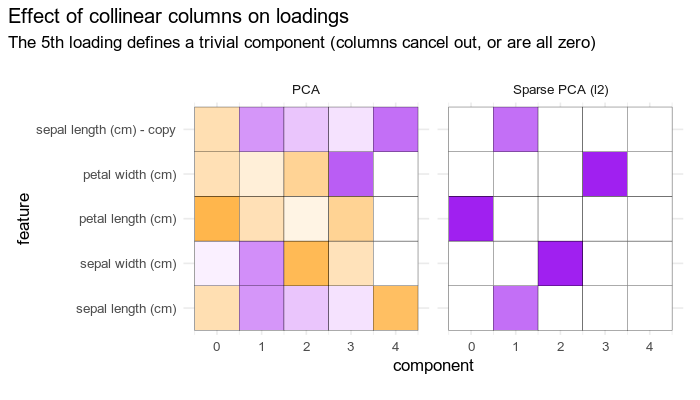

In [13]:
%%R -i loadings_by_penalty -r 110 -w 700 -h 400
patchwork::wrap_elements(
    ggplot(loadings_by_penalty, aes(y=feature, x=component, fill=value))
    + facet_wrap('penalty')
    + geom_tile(color='black')
    + theme_minimal()
    + scale_fill_gradient2(low='purple', high='orange')
    + coord_fixed()
    + theme(legend.position='none')
) + labs(
    title='Effect of collinear columns on loadings',
    subtitle='The 5th loading defines a trivial component (columns cancel out, or are all zero)'
)

## Example: MNIST dataset

In [14]:
mnist = datasets.fetch_openml('mnist_784', version=1)

In [15]:
standard_scale_pca = make_pipeline(StandardScaler(), PCA())
standard_scale_pca.fit(mnist.data)
pca = standard_scale_pca.steps[-1][1]

In [16]:
from pandas import Series

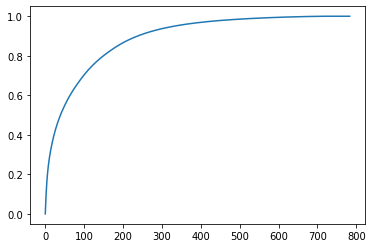

In [17]:
r2_mnist = Series({
    i: sum(pca.explained_variance_ratio_[:i])
    for i in range(len(pca.explained_variance_ratio_))
})
r2_mnist.plot();

In [18]:
len(r2_mnist)

784

In [55]:
mnist_thresholds = {
    threshold: r2_mnist[r2_mnist > threshold].index[0]
    for threshold in [0.75, 0.85, 0.90, 0.95]
}
mnist_thresholds

{0.75: 121, 0.85: 186, 0.9: 238, 0.95: 332}

In [20]:
mnist_data = DataFrame(mnist.data)

In [21]:
%R -i mnist_data

In [ ]:
%%R
library(pcaMethods)

pcIr <- pca(mnist_data, scale='uv', nPcs=10)

In [167]:
%%R
q2 <- Q2(pcIr, x)
q2

        PC 1         PC 2         PC 3         PC 4 
-0.008154728 -0.014007438 -0.019398150 -0.023613524 


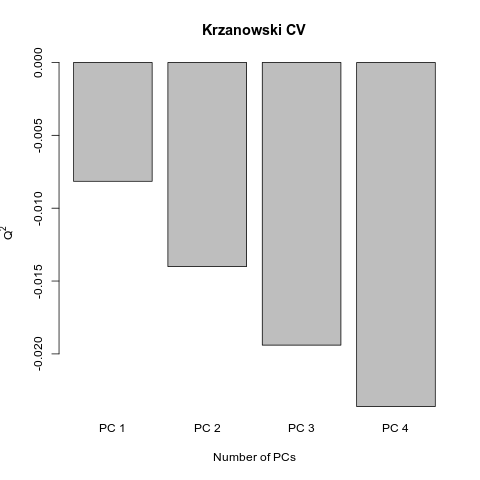

In [168]:
%%R
barplot(q2, main="Krzanowski CV", xlab="Number of PCs", ylab=expression(Q^2))

In [22]:
from loadings_similarity import loadings_similarity
from sklearn.model_selection import KFold
from pandas import concat

### Correlations behaviour

In [23]:
mnist_large_n = loadings_similarity(
    standard_scale_pca, mnist.data,
    limit_to_n_components=325, cv=KFold(3)
)

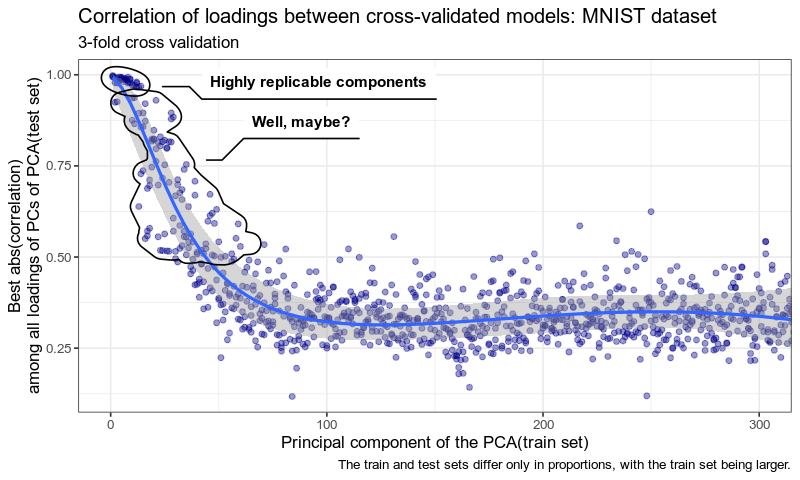

In [27]:
%%R -i mnist_large_n -w 800 -r 110
(
    ggplot(mnist_large_n, aes(x=n, y=best_abs_corr))
    + geom_point(alpha=0.4, color='darkblue')
    + theme_bw()
    + xlab('Principal component of the PCA(train set)')
    + ylab('Best abs(correlation)\namong all loadings of PCs of PCA(test set)')
    + labs(
        title='Correlation of loadings between cross-validated models: MNIST dataset',
        subtitle='3-fold cross validation',
        caption=paste0(
            'The train and test sets differ only in proportions, with the train set being larger.'
        )
    )
    + coord_cartesian(xlim=c(0, 300))
    + geom_smooth(
        method='glm',
        method.args=list(family='binomial'),
        formula=y~x*sqrt(x)
    )
    + ggforce::geom_mark_ellipse(
        aes(filter=best_abs_corr > 0.95, label='Highly replicable components'),
        label.fontsize=10,
        expand=unit(2, 'mm')
    )
    + ggforce::geom_mark_hull(
        aes(filter=best_abs_corr < 0.95 & best_abs_corr > 0.5 & n < 100, label='Well, maybe?'),
        label.fontsize=10,
        expand=unit(2, 'mm')
    )
)

### Correlations by number of folds

In [28]:
k_folds = range(2, 11)

In [29]:
mnist_by_k = concat(
    loadings_similarity(
        standard_scale_pca, mnist.data,
        limit_to_n_components=125, cv=KFold(k)
    ).assign(k=k)
    for k in k_folds
)

In [30]:
%%R
folds_colors = rev(colorspace::darken(RColorBrewer::brewer.pal(11, 'RdYlGn')))
folds_colors_scale = scale_color_manual(values=folds_colors, name='k folds')

binomial_sqrt_smooth = function(...) {
    geom_smooth(
        method='glm',
        method.args=list(family='binomial'),
        formula=y~x*sqrt(x),
        ...
    )
}

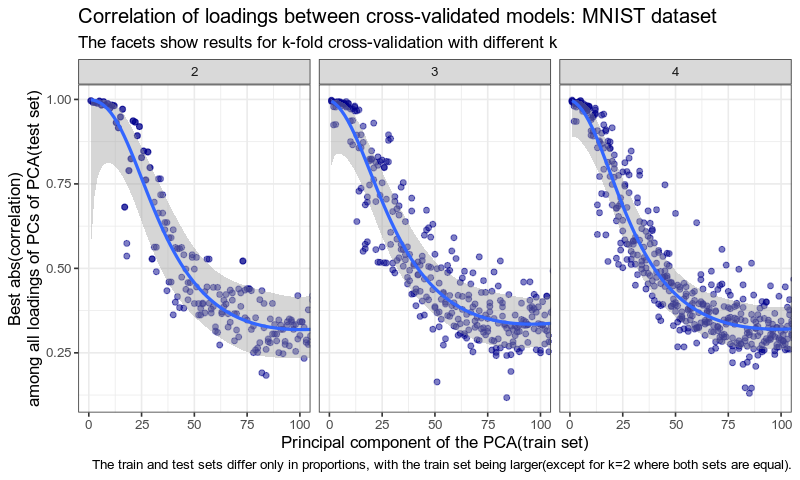

In [31]:
%%R -i mnist_by_k -w 800 -r 110
(
    ggplot(mnist_by_k[mnist_by_k$k < 5, ], aes(x=n, y=best_abs_corr))
    + facet_wrap('k')
    + geom_point(alpha=0.5, color='darkblue')
    + binomial_sqrt_smooth()
    # this is needed so we fit smooth on the 0-125 range and only then clip (xlim does not work)
    + coord_cartesian(xlim=c(0, 100))
    + ylab('Best abs(correlation)\namong all loadings of PCs of PCA(test set)')
    + xlab('Principal component of the PCA(train set)')
    + labs(
        title='Correlation of loadings between cross-validated models: MNIST dataset',
        subtitle='The facets show results for k-fold cross-validation with different k',
        caption=paste0(
            'The train and test sets differ only in proportions, with the train set being larger',
            '(except for k=2 where both sets are equal).'
        )
    )
    + theme_bw()
)

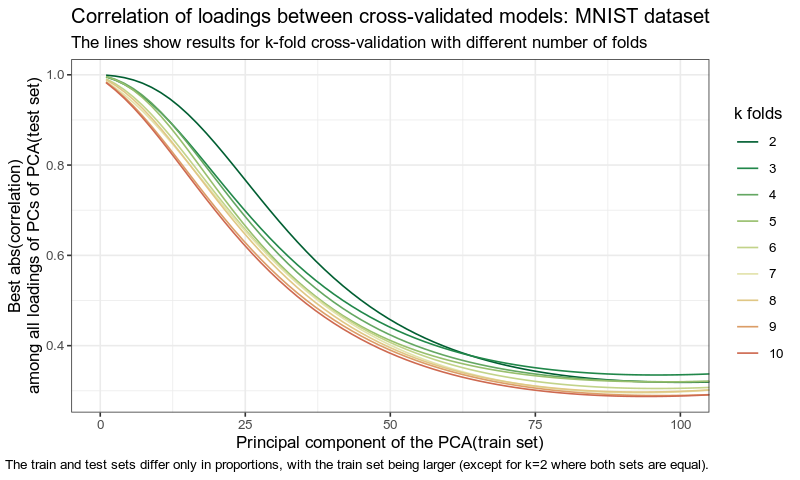

In [32]:
%%R -i mnist_by_k -w 800 -r 110
(
    ggplot(mnist_by_k, aes(x=n, y=best_abs_corr, group=k, color=as.factor(k)))
    + binomial_sqrt_smooth(se=F, size=0.5)
    + folds_colors_scale
    # this is needed so we fit smooth on the 0-125 range and only then clip (xlim does not work)
    + coord_cartesian(xlim=c(0, 100))
    + ylab('Best abs(correlation)\namong all loadings of PCs of PCA(test set)')
    + xlab('Principal component of the PCA(train set)')
    + labs(
        title='Correlation of loadings between cross-validated models: MNIST dataset',
        subtitle='The lines show results for k-fold cross-validation with different number of folds',
        caption=paste0(
            'The train and test sets differ only in proportions, with the train set being larger',
            ' (except for k=2 where both sets are equal).'
        )
    )
    + theme_bw()
)

### Ranks correspondence

R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



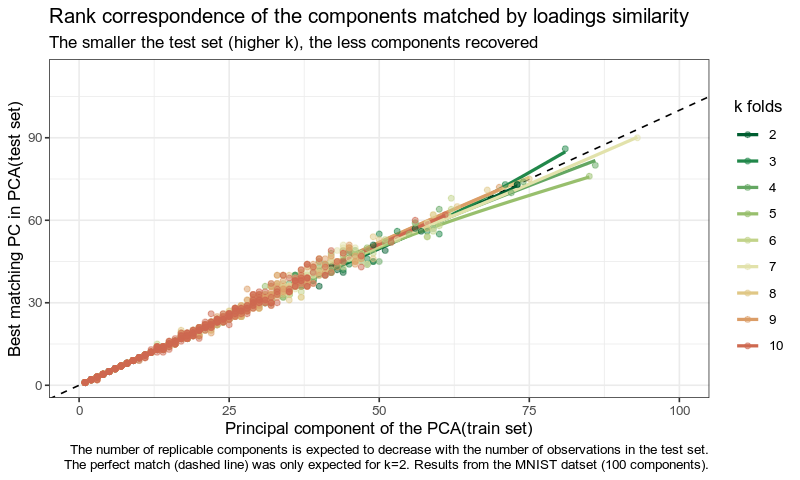

In [33]:
%%R -i mnist_by_k -w 800 -r 110
(
    ggplot(mnist_by_k, aes(x=n, y=corresponding_pc_in_test, group=k, color=as.factor(k)))
    + geom_abline(slope=1, intercept=0, linetype='dashed')
    + ylab('Best matching PC in PCA(test set)')
    + xlab('Principal component of the PCA(train set)')
    + geom_smooth(se=F)
    + xlim(0, 100)
    + folds_colors_scale
    + labs(
        title='Rank correspondence of the components matched by loadings similarity',
        subtitle='The smaller the test set (higher k), the less components recovered',
        caption=paste0(
            'The number of replicable components is expected to decrease with the number of observations in the test set.\n',
            'The perfect match (dashed line) was only expected for k=2. Results from the MNIST datset (100 components).'
        )
    )
    + geom_point(alpha=0.5)
    + theme_bw()
)

### Number of components

In [89]:
repeated_mnist_by_k = concat(
    loadings_similarity(
        standard_scale_pca, mnist.data,
        limit_to_n_components=125, cv=RepeatedKFold(k)
    ).assign(k=k)
    for k in k_folds
)

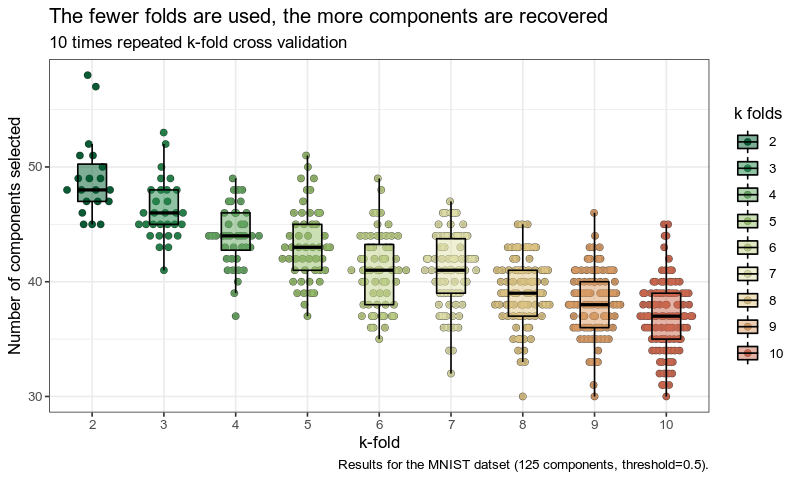

In [178]:
%%R -i repeated_mnist_by_k -w 800 -r 110
df = repeated_mnist_by_k

(
    ggplot(df[df$n==1, ], aes(x=as.factor(k), y=keep_n, fill=as.factor(k), color=as.factor(k)))
    + ylab('Number of components selected')
    + xlab('k-fold')
    + scale_fill_manual(values=folds_colors, name='k folds')
    + folds_colors_scale
    + labs(
        title='The fewer folds are used, the more components are recovered',
        subtitle='10 times repeated k-fold cross validation',
        caption=paste0(
            'Results for the MNIST datset (125 components, threshold=0.5).'
        )
    )
    + ggbeeswarm::geom_quasirandom(alpha=0.7, color='black', size=1.7)
    + ggbeeswarm::geom_quasirandom(alpha=0.8)
    + geom_boxplot(alpha=.5, color='black', notch=F, outlier.shape=NA, width=0.4)
    + theme_bw()
)

In [91]:
repeated_mnist_by_k.query('k == 2').keep_n.median()

48.0

Is 48 components enough?

In [95]:
standard_scale_pca_subset = make_pipeline(StandardScaler(), PCA(n_components=48))

result = standard_scale_pca_subset.inverse_transform(
    standard_scale_pca_subset.fit_transform(mnist.data)
)

In [96]:
sum(standard_scale_pca_subset.steps[-1][1].explained_variance_ratio_)

0.5406001583419908

In [97]:
from helpers import plot_digits_row

In [98]:
def plot_digits(*args, **kwargs):
    return plot_digits_row(*args, mnist.target, **kwargs)

While the individuals observations do not look great:

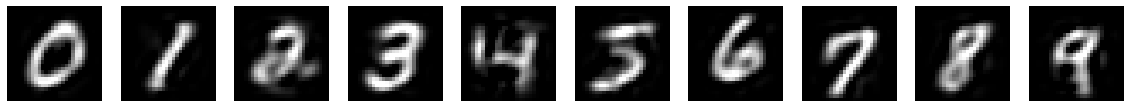

In [100]:
plot_digits(result);

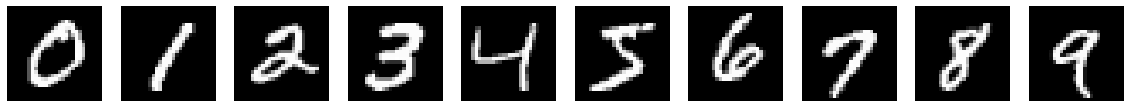

In [42]:
plot_digits(mnist.data);

The comparison of 100-averages is truly convincing:

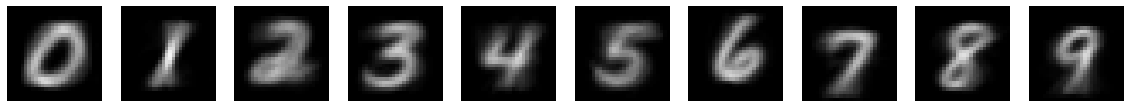

In [43]:
plot_digits(mnist.data, average_of=100);

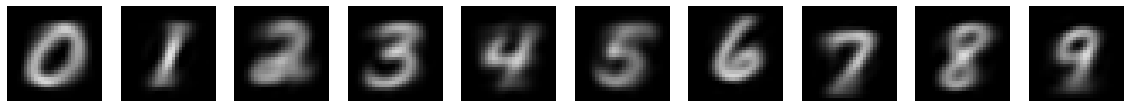

In [99]:
plot_digits(result, average_of=100);

## Improvements

### Distance correction

In [45]:
mnist_by_k_distance_corrected = concat(
    loadings_similarity(
        standard_scale_pca, mnist.data,
        limit_to_n_components=125, cv=KFold(k),
        distance_correction=True
    ).assign(k=k)
    for k in k_folds
)

R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



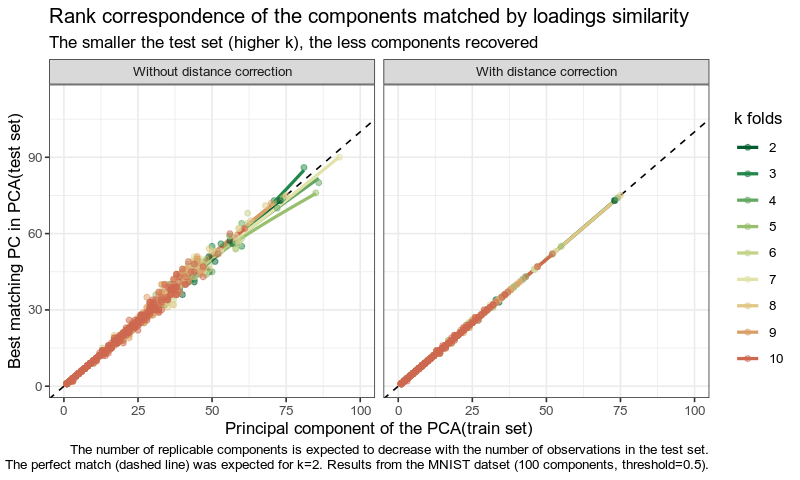

In [46]:
%%R -i mnist_by_k_distance_corrected -w 800 -r 110
mnist_by_k$distance_corrected = 'Without distance correction'
mnist_by_k_distance_corrected$distance_corrected = 'With distance correction'
df = rbind(mnist_by_k, mnist_by_k_distance_corrected)
df$distance_corrected = factor(df$distance_corrected, ordered=T, levels=c('Without distance correction', 'With distance correction'))

(
    ggplot(df, aes(x=n, y=corresponding_pc_in_test, group=k, color=as.factor(k)))
    + facet_wrap('distance_corrected')
    + geom_abline(slope=1, intercept=0, linetype='dashed')
    + ylab('Best matching PC in PCA(test set)')
    + xlab('Principal component of the PCA(train set)')
    + geom_smooth(se=F)
    + xlim(0, 100)
    + folds_colors_scale
    + labs(
        title='Rank correspondence of the components matched by loadings similarity',
        subtitle='The smaller the test set (higher k), the less components recovered',
        caption=paste0(
            'The number of replicable components is expected to decrease with the number of observations in the test set.\n',
            'The perfect match (dashed line) was expected for k=2. Results from the MNIST datset (100 components, threshold=0.5).'
        )
    )
    + geom_point(alpha=0.5)
    + theme_bw()
)

### Adaptive threshold

In [145]:
from loadings_similarity import threshold_adaptive

In [153]:
mnist_adaptive = concat([
    loadings_similarity(
        standard_scale_pca,
        mnist.data,
        cv=KFold(2),
        limit_to_n_components=125,
        threshold_modifier=threshold_adaptive(components_importance_measure=measure, combine=combine)
    ).assign(importance_measure=measure, combine='sqrt(train * test) importance' if combine else 'train importance')
    for measure in ['individual', 'cumulative']
    for combine in [True, False]
])

In [154]:
mnist_adaptive.groupby(['importance_measure', 'combine']).keep_n.median().to_frame()

keep_n
importance_measure combine                              
cumulative         sqrt(train * test) importance      40
                   train importance                   40
individual         sqrt(train * test) importance       9
                   train importance                    9

In [156]:
mnist_adaptive.query('combine == "sqrt(train * test) importance" and importance_measure == "cumulative"').adjusted_threshold.max()

0.7733371199027886

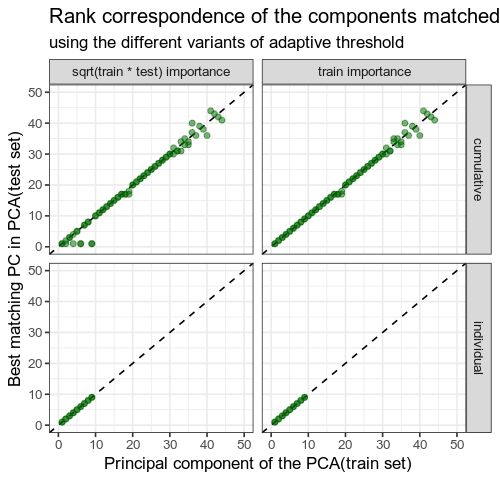

In [165]:
%%R -i mnist_adaptive -w 500 -r 110

(
    ggplot(mnist_adaptive, aes(x=n, y=corresponding_pc_in_test))
    + facet_grid(importance_measure ~ combine)
    + geom_abline(slope=1, intercept=0, linetype='dashed')
    + ylab('Best matching PC in PCA(test set)')
    + xlab('Principal component of the PCA(train set)')
    + folds_colors_scale
    + xlim(0, 50)
    + ylim(0, 50)
    #+ coord_fixed()
    + labs(
        title='Rank correspondence of the components matched',
        subtitle='using the different variants of adaptive threshold'
    )
    + geom_point(alpha=0.5, color='darkgreen')
    + theme_bw()
)

## Classification using LASSO logistic regression

Note: logistic regression in sklearn by default uses l2 penalty.

In [52]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

Using CV version (i.e. with cross-validation) as it is important to tune hyperparameters when comparing the preprocessing methods.

In [53]:
train_X, test_X, train_y, test_y = train_test_split(
    mnist.data, mnist.target,
    test_size=1/7, random_state=0
)

In [59]:
%%time
pipeline_95_var = make_pipeline(
    StandardScaler(),
    PCA(n_components=mnist_thresholds[0.95]),
    LogisticRegressionCV(solver='lbfgs', n_jobs=6, max_iter=500)
)
pipeline_95_var.fit(train_X, train_y);

CPU times: user 2min 33s, sys: 1min 5s, total: 3min 38s
Wall time: 10min 8s


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=332,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=500, multi_class='auto',
                                      n_jobs=6, penalty='l2', random_state=None,
                                      refit=True, scoring=None, solver='lbfgs',
                                      tol=0.0001, verbose=0))],
         verbose=False)

In [102]:
%%time
pipeline_85_var = make_pipeline(
    StandardScaler(),
    PCA(n_components=mnist_thresholds[0.85]),
    LogisticRegressionCV(solver='lbfgs', n_jobs=6, max_iter=500)
)
pipeline_85_var.fit(train_X, train_y);

CPU times: user 3min 6s, sys: 1min 48s, total: 4min 54s
Wall time: 6min 45s


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=186,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=500, multi_class='auto',
                                      n_jobs=6, penalty='l2', random_state=None,
                                      refit=True, scoring=None, solver='lbfgs',
                                      tol=0.0001, verbose=0))],
         verbose=False)

In [101]:
%%time
pipeline_48 = make_pipeline(
    StandardScaler(),
    PCA(n_components=48),
    LogisticRegressionCV(solver='lbfgs', n_jobs=6, max_iter=500)
)
pipeline_48.fit(train_X, train_y);

CPU times: user 1min 16s, sys: 50.2 s, total: 2min 6s
Wall time: 1min 42s


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=48,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=500, multi_class='auto',
                                      n_jobs=6, penalty='l2', random_state=None,
                                      refit=True, scoring=None, solver='lbfgs',
                                      tol=0.0001, verbose=0))],
         verbose=False)

In [66]:
from sklearn.metrics import classification_report

In [68]:
print(classification_report(test_y, pipeline_95_var.predict(test_X)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       996
           1       0.96      0.97      0.96      1141
           2       0.90      0.89      0.90      1040
           3       0.91      0.88      0.90      1013
           4       0.91      0.93      0.92       962
           5       0.88      0.88      0.88       863
           6       0.95      0.95      0.95       989
           7       0.93      0.92      0.93      1064
           8       0.89      0.89      0.89       963
           9       0.89      0.90      0.90       969

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [69]:
print(classification_report(test_y, pipeline_48.predict(test_X)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       996
           1       0.94      0.98      0.96      1141
           2       0.89      0.88      0.88      1040
           3       0.88      0.87      0.87      1013
           4       0.89      0.92      0.91       962
           5       0.86      0.84      0.85       863
           6       0.93      0.95      0.94       989
           7       0.94      0.91      0.92      1064
           8       0.87      0.85      0.86       963
           9       0.86      0.87      0.87       969

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [103]:
cases = {
    'loadings correlations': [pipeline_48, 48, '1min 42s'],
    f'85% variance explained': [pipeline_85_var, mnist_thresholds[0.85], '6min 39s'],
    f'95% variance explained': [pipeline_95_var, mnist_thresholds[0.95], '10min 8s'],
}

results = DataFrame([
    {'score': pipeline.score(test_X, test_y), 'name': name, 'components': components, 'total time': time}
    for name, (pipeline, components, time) in cases.items()
]).set_index('name')
results

,score,components,total time
name,,,
loadings correlations,0.9010,48,1min 42s
85% variance explained,0.9200,186,6min 39s
95% variance explained,0.9202,332,10min 8s
